## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [101]:
import string
import os
import re
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%config InlineBackend.figure_format='retina'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [102]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [103]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
# print('OK!')

### Data loading: "Евгений Онегин"


In [104]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [105]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
ST = "*"

text = [ST + x.lower() for x in text if x != '\n']
text = [re.sub(' +', ' ', x) for x in text]

text = ''.join(text)
print(text[:116])

*i
*«мой дядя самых честных правил,
*когда не в шутку занемог,
*он уважать себя заставил
*и лучше выдумать не мог.
*


Put all the characters, that you've seen in the text, into variable `tokens`.

In [106]:
PAD = '_'

In [107]:
tokens = sorted(set(''.join(text)))
tokens.append(PAD)
print(tokens)
num_tokens = len(tokens)

['\n', ' ', '!', '(', ')', '*', ',', '-', '.', '5', '7', '8', '9', ':', ';', '?', '[', ']', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '–', '—', '’', '…', '€', '_']


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [108]:
# dict <index>:<char>
# Your great code here
idx_to_token = {idx: ch for idx, ch in enumerate(tokens)}

# dict <char>:<index>
# Your great code here

token_to_idx = {ch: idx for idx, ch in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [109]:
def make_matr(sents, max_len = None, pad=PAD, dtype='int32', batch_first=True):
    max_len = max_len or max(map(len, sents))
    sents_ix = np.zeros([len(sents), max_len], dtype) + token_to_idx[PAD]

    for i in range(len(sents)):
        l_i = [token_to_idx[c] for c in sents[i]]
        sents_ix[i, :len(l_i)] = l_i[:max_len]
        
    if not batch_first:
        sents_ix = np.transpose(sents_ix)

    return sents_ix

In [110]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=512):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        

        next_h = self.rnn_update(torch.cat([x_emb, h_prev], dim=-1))
        next_h = torch.tanh(next_h)
    
        
        logits = self.rnn_to_logits(next_h)
        
        return next_h, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

In [111]:
def loop_rnn(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    h_st = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        h_st, logp_next = char_rnn(x_t, h_st)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [112]:
char_rnn = CharRNNCell().to(device)
criterion = nn.NLLLoss(ignore_index = token_to_idx[PAD])
opt = torch.optim.Adam(char_rnn.parameters(), lr=0.0001)
history = []

In [113]:
batch_ix = make_matr(text)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

lgp_sq = loop_rnn(char_rnn, batch_ix)

pred_lgp = lgp_sq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(pred_lgp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))


In [114]:
def get_sbstr(main_str, num_sbstr, sbstr_len):
    result = []
    for i in range(num_sbstr):
        idx = random.randrange(0, len(main_str) - sbstr_len + 1)
        result.append(main_str[idx : (idx+sbstr_len)])
    return result

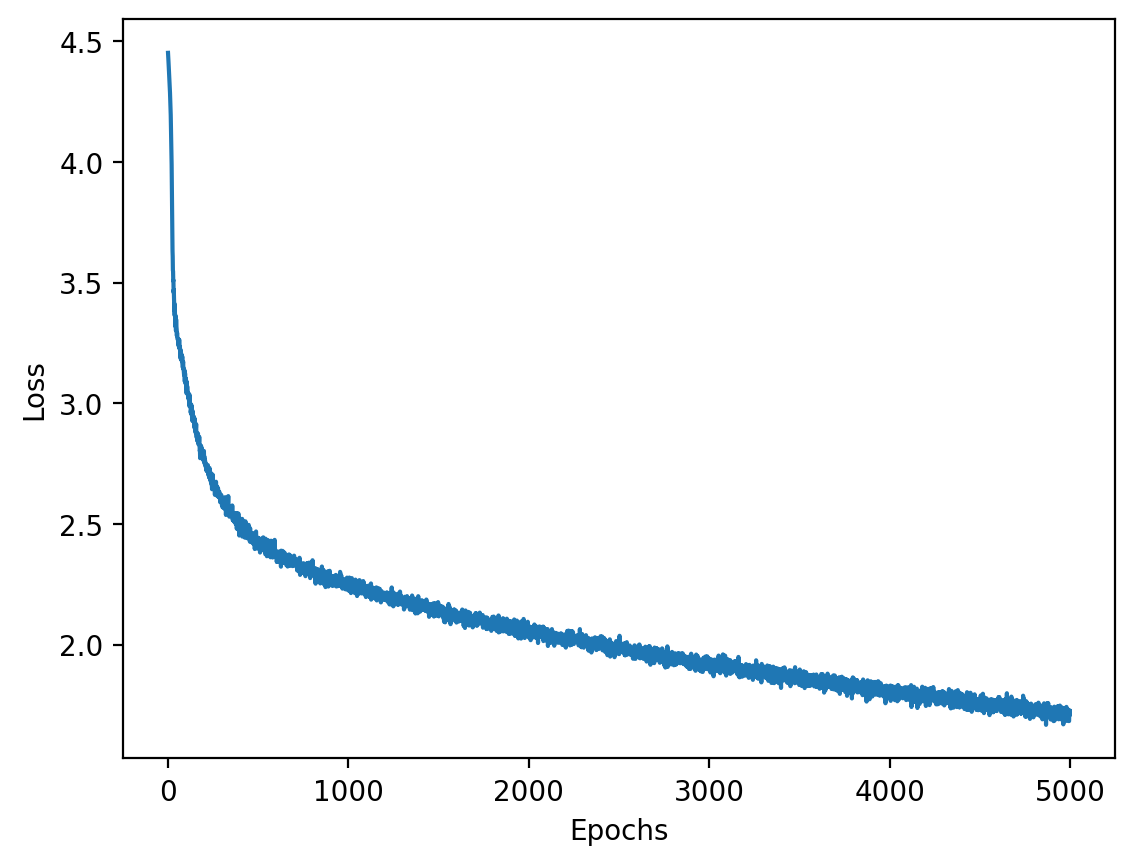

In [115]:

history = []

for i in range(5000):
    subtext = get_sbstr(text, 128, 64)
    
    batch_ix = make_matr(subtext, max_len=64)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    lgp_sq = loop_rnn(char_rnn, batch_ix)
    
    pred_lgp = lgp_sq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(pred_lgp.contiguous().view(-1, len(tokens)), 
                    actual_next_tokens.contiguous().view(-1))
    

    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_value = loss.data.cpu().numpy()
    
    history.append(loss.data.cpu().numpy())

plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(history)

plt.show()


In [116]:
def generate_sample(char_rnn, seed_phrase='  ', max_length=100, temperature=1.0):    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    h_st = char_rnn.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        h_st, out = char_rnn(x_sequence[:, i], h_st)
    
    
    for i in range(max_length - len(seed_phrase)):
        h_st, out = char_rnn(x_sequence[:, -1], h_st)
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    result = ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0] if tokens[ix] != ST])
    
    return result

In [117]:
# An example of generated text.
result = generate_sample(char_rnn, seed_phrase='*во саду ли', max_length=300, temperature=0.1)
print(result)

во саду ли в сердце настали
и в сердце в нем обеданья,
и слез мой верно последней,
не постеле страсти молодой,
и страсти молча и в том не своей,
и слез мой приятный полет
и в сердце в сердце в сердце волод
в сем сердце в нем обеданья,
не последней сердце в нем собранье
старинный полно с не


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [118]:
class CharLSTMCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=64, lstm_num_units=512):
        super(self.__class__, self).__init__()
        self.num_units = lstm_num_units
        self.emb = nn.Embedding(len(tokens), emb_size)
        self.lstm = nn.LSTM(emb_size, self.num_units, batch_first=True)
        
        self.hid_to_logits = nn.Linear(self.num_units, num_tokens)

    def forward(self, x, hidden=None):
        h_seq, hidden = self.lstm(self.emb(x), hidden)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

In [119]:
char_lstm = CharLSTMCell().to(device)
criterion = nn.NLLLoss(ignore_index = token_to_idx[PAD])
opt = torch.optim.Adam(char_lstm.parameters(), lr=0.0001)
lstm_history = []

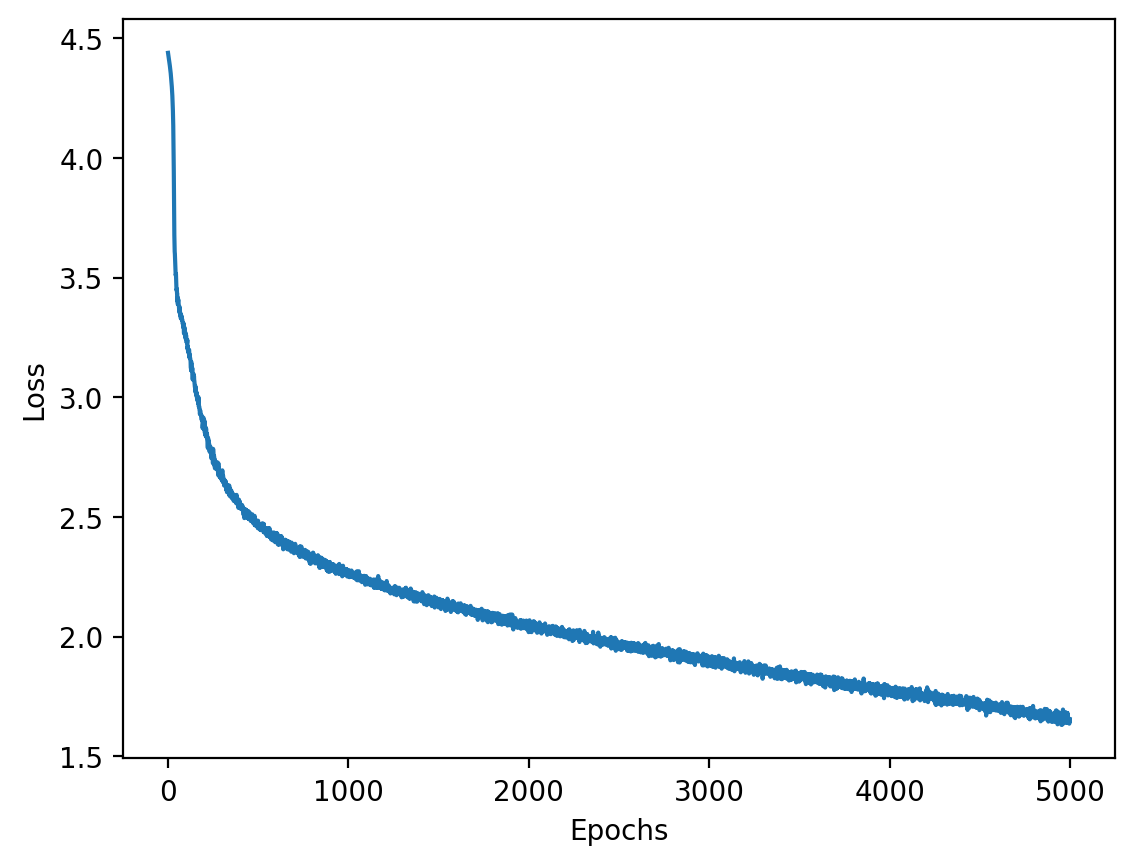

In [120]:
for i in range(5000):
    subtext = get_sbstr(text, 256, 64)
    
    batch_ix = make_matr(subtext, max_len=64)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    lgp_sq, i = char_lstm(batch_ix)
    
    # compute loss
    pred_lgp = lgp_sq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(pred_lgp.contiguous().view(-1, len(tokens)), 
                    actual_next_tokens.contiguous().view(-1))

    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_value = loss.data.cpu().numpy()
    
    lstm_history.append(loss.data.cpu().numpy())


plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(lstm_history)

plt.show()


In [121]:
def generate_sample_lstm(char_lstm, seed_phrase=' ', max_length=100, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    h_state = torch.zeros(1, 1, char_lstm.num_units, device=device)
    c_state = torch.zeros(1, 1, char_lstm.num_units, device=device)

    # Process the seed phrase if it's longer than one character
    for i in range(len(seed_phrase) - 1):
        _, (h_state, c_state) = char_lstm(x_sequence[:, i].unsqueeze(0), (h_state, c_state))

    # Generate new characters
    for i in range(max_length - len(seed_phrase)):
        logits, (h_state, c_state) = char_lstm(x_sequence[:, -1].unsqueeze(0), (h_state, c_state))
        p_next = F.softmax(logits / temperature, dim=-1).data.cpu().numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next.ravel())
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    result = ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0] if tokens[ix] != ST])
    return result


In [122]:
result = generate_sample_lstm(char_lstm, seed_phrase='*во саду ли', max_length=300, temperature=0.1)
print(result)

во саду ли в том с ней она
с ней онегин со своей доло
на старой под нем она света,
и в самом деле постеле
и слава с ней не полно вань
он страстно предного страстей
не после постели в семья,
под нем онегин старина
и в соседенный в семью друг,
и в том с ней не страсте не знал.
xxxii
но в н


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [123]:
temperature = [0.1, 0.2, 0.5, 1.0, 2.0]

for temp in temperature:

    result = generate_sample_lstm(char_lstm, seed_phrase='*мой дядя', max_length=300, temperature=temp)
    print('Tempreture {:.2f}'.format(temp))
    print(result)
    print()

Tempreture 0.10
мой дядя с ней и соседеньем
он страстно преднивая старит
и в том старый под нем она.
xxxii
она в самом деле не сенья
с ней онегин со своей сторой
с ней не после татьяна стала,
под ней онегин с ним обранье
старинный сон страстно признать.
не том, он он старина слада
и в том с постеленный п

Tempreture 0.20
мой дядя с постоми света,
и не заметали в сенье
мечтанье молча и подама
и страстей родной светельной
и перестались в постеле
и простительный признать.
xxxvii
и вот он был он страсти своей
в сердцем вести соседенный вол
и страстей не страсти подруги
и после мой своей полет
и нас одновать 

Tempreture 0.50
мой дядя тредительный глад,
старой достовой, он жений,
и перед нем болодахом,
в тему слезится, подрады,
он гояльной полный водом,
и в сладость меня подруга.
онегин стол было долженье,
глядит, неду не полет
и наше верновите состанье
меня предмете домый сем
сердца татьяна старина
и не смел

Tempreture 1.00
мой дядя зебя бадсов, тежно
отновить ость. ю. пово мне,
оно все д

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [124]:
torch.save(char_lstm.state_dict(), 'lstm_save.pth')

In [125]:
new_lstm = CharLSTMCell()
new_lstm.load_state_dict(torch.load('lstm_save.pth'))
new_lstm.to(device)

CharLSTMCell(
  (emb): Embedding(85, 64)
  (lstm): LSTM(64, 512, batch_first=True)
  (hid_to_logits): Linear(in_features=512, out_features=85, bias=True)
)

In [126]:
result = generate_sample_lstm(new_lstm, seed_phrase='*с послом испанским говорит', max_length=300, temperature=0.1)
print(result)

с послом испанским говорит,
и в том с сердце вольно послужна
старинный город собой,
и в самом деле не соне
с ним он верем он верели мно
не старина старина сона
и в садами старины своей
простите приводит она старит
и в сем сердце вольном своей
не воста приятно старина
и в том с постеленный


# Выводы

Vanilla RNN может быть обучена. Текст получается плохо связный, но слова в основном верные. Изредка соблюдается рифма. Обучение проводил на 5.000 эпох. 
При использовании LSTM время обучения существенно увеличивается.

Использование LSTM вместо RNN улучшает обучение, и после 5000 эпох финальное значение loss оказывается ниже. Модель LSTM строит текст интереснее, более похож на написанный человеком. Однако на обучение модели требуется  больше времени.

Параметр temperature отвечает за то насколько случайным будет выбор следующего токена. Как видно из опыта, модель LSTM при низких значения temperature 0.1 и 0.2 генерирует идентичный текст при одинаковом seed. При увеличении значения параметра сгенерированный текст становится более хаотичным, появляются несуществующие слова и теряется рифма.



### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)